In [1]:
import os
import sys
# Set paths relative to this notebook (in notebooks/)
# We assume structure: .../readmit30/notebooks (cwd)
#                      .../readmit30/scripts/data
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f'Base dir (readmit30): {base_dir}')
os.environ['TRAIN_PATH'] = os.path.join(base_dir, 'scripts', 'data', 'public', 'train.csv')
os.environ['DEV_PATH']   = os.path.join(base_dir, 'scripts', 'data', 'public', 'dev.csv')
os.environ['TEST_PATH']  = os.path.join(base_dir, 'scripts', 'data', 'public', 'public_test.csv')
os.environ['OUT_PATH']   = 'predictions.csv'

print('Environment variables set for local execution.')


Base dir (readmit30): C:\github\aihc2026\AIHC-5010-Winter-2026\Project-1\readmit30
Environment variables set for local execution.


# Assignment 1 — Colab Workflow (GitHub + Pre-commit + Submission Validation)

This notebook teaches the standard workflow used throughout the course:

1. Clone your team repo
2. Install dependencies
3. Install **pre-commit** and enable a hook to strip notebook outputs
4. Run this notebook end-to-end
5. Validate `predictions.csv`
6. Commit + push + tag


In [2]:
# (Colab) show python and system info
import sys, platform
print(sys.version)
print(platform.platform())


3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Windows-11-10.0.26200-SP0


## 1) Clone Repo

Login to your personal Github account, and make a fork of: https://github.com/TLKline/AIHC-5010-Winter-2026

Follow setup directions for working with a PAT in GitHub (30-second guide):

* Go to GitHub → Settings
* Developer settings
* Personal access tokens
* Choose:
  * Fine-Grained

You can clone using HTTPS.

Repo HTTPS URL (e.g., `https://github.com/TLKline/AIHC-5010-Winter-2026.git`)

## 2) Install dependencies

This installs whatever is in `requirements.txt`.


In [3]:
!pip -q install -r Project-1/readmit30/requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'Project-1/readmit30/requirements.txt'


#MAINSTART

# 4) Submission Notebook (Template)

Replace the baseline model with your team’s approach.

In [4]:
import os
from pathlib import Path

TRAIN_PATH = os.environ.get("TRAIN_PATH", "../scripts/data/public/train.csv")
DEV_PATH   = os.environ.get("DEV_PATH",   "../scripts/data/public/dev.csv")
TEST_PATH  = os.environ.get("TEST_PATH",  "../scripts/data/public/public_test.csv")
OUT_PATH   = os.environ.get("OUT_PATH",   "predictions.csv")

print("TRAIN_PATH:", TRAIN_PATH)
print("DEV_PATH:", DEV_PATH)
print("TEST_PATH:", TEST_PATH)
print("OUT_PATH:", OUT_PATH)

TRAIN_PATH: C:\github\aihc2026\AIHC-5010-Winter-2026\Project-1\readmit30\scripts\data\public\train.csv
DEV_PATH: C:\github\aihc2026\AIHC-5010-Winter-2026\Project-1\readmit30\scripts\data\public\dev.csv
TEST_PATH: C:\github\aihc2026\AIHC-5010-Winter-2026\Project-1\readmit30\scripts\data\public\public_test.csv
OUT_PATH: predictions.csv


In [5]:
import numpy as np
import pandas as pd
np.random.seed(42)

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

assert "row_id" in train.columns and "readmit30" in train.columns
assert "row_id" in test.columns

X_train = train.drop(columns=["readmit30"])
y_train = train["readmit30"].astype(int)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# TODO: Add any new imports for your own method here
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

method = 1

cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
)

if method==1:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200)),
    ])

if method==2:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200,class_weight='balanced')),
    ])

if method==3:
    # Use SVC (i.e. SVM model)
    clf = Pipeline(
        [
            ("preprocess", preprocess),
            ("scaler", StandardScaler(with_mean=False)), # Add StandardScaler here
            ("model", SVC(gamma="auto",max_iter=1000,probability=True)),
        ]
    )

if method == 4:
    # Preprocess for HGB: ordinal-encode categories (HGB needs numeric inputs)
    preprocess_hgb = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
            ]), cat_cols),
        ],
        remainder="drop",
    )

    clf = Pipeline([
        ("preprocess", preprocess_hgb),
        ("model", HistGradientBoostingClassifier(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42,
            class_weight='balanced',
        )),
    ])

clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
p_test = clf.predict_proba(test)[:, 1]
pred = pd.DataFrame({"row_id": test["row_id"].astype(int), "prob_readmit30": p_test.astype(float)})
pred.to_csv(OUT_PATH, index=False)
pred.head()

,row_id,prob_readmit30
0,103521306,0.277139
1,127919112,0.137758
2,233245326,0.090782
3,236785056,0.055595
4,131110896,0.118291


In [8]:
# Validate output format (required for students before tagging)
!python ../scripts/validate_submission.py --pred {OUT_PATH} --test {TEST_PATH}


OK: predictions.csv format is valid.


AUROC: 0.4919
AUPRC: 0.1076
Brier Score: 0.1202


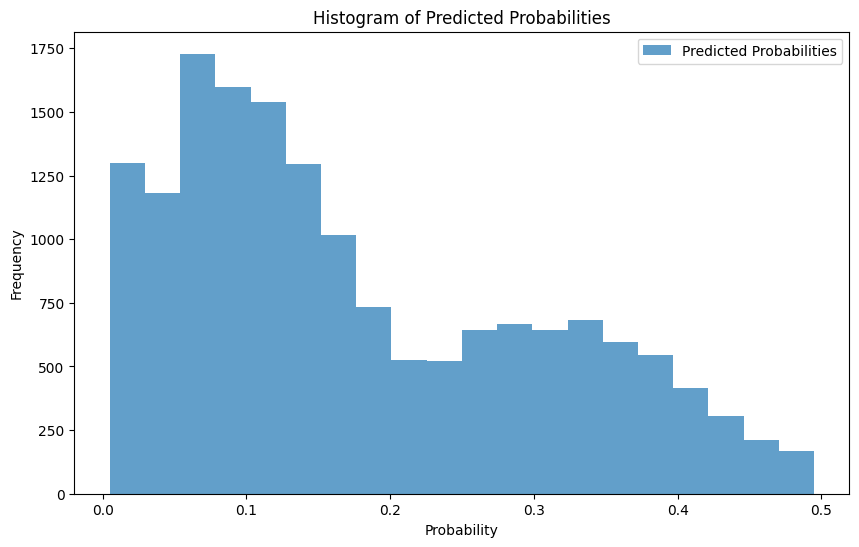

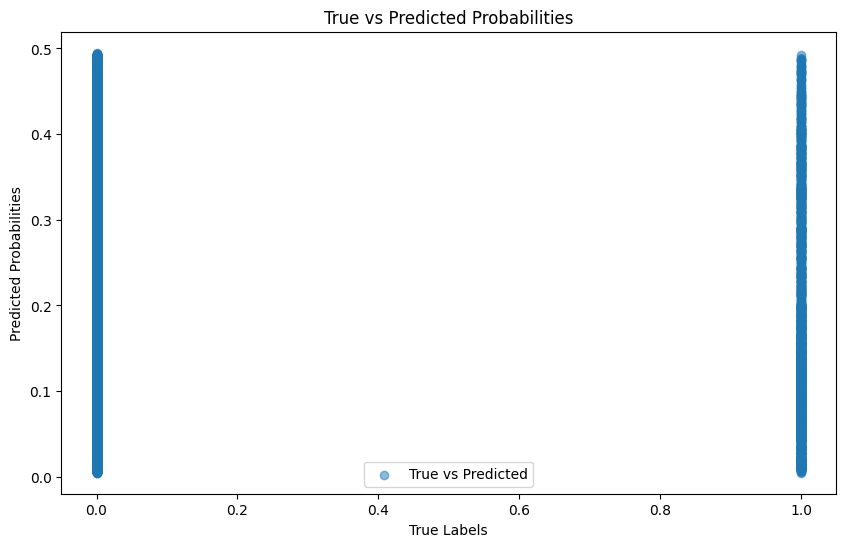

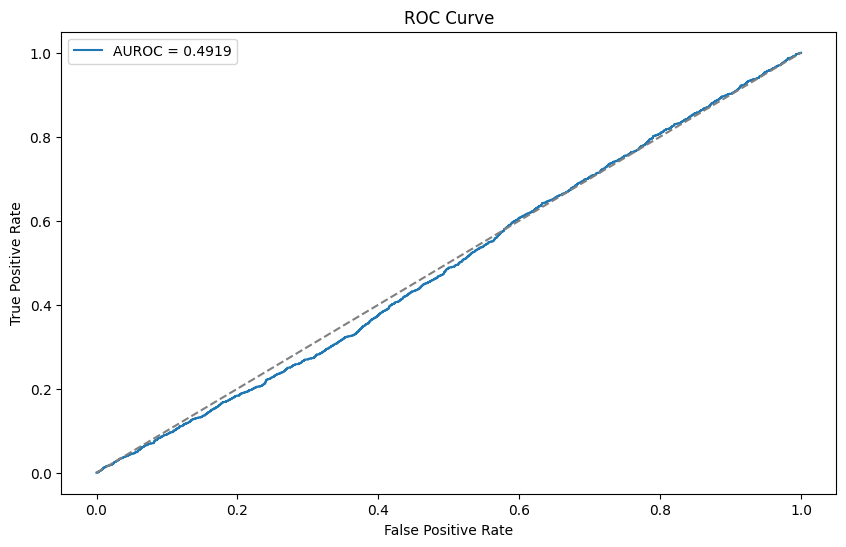

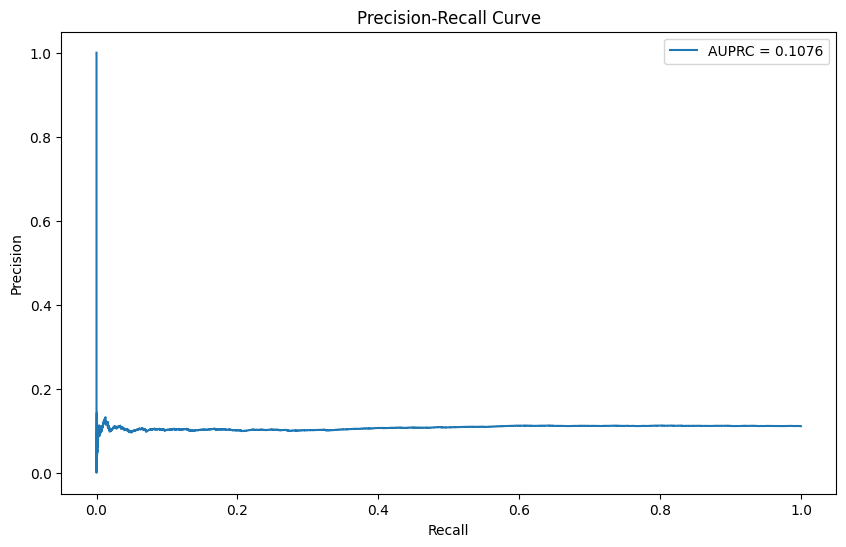

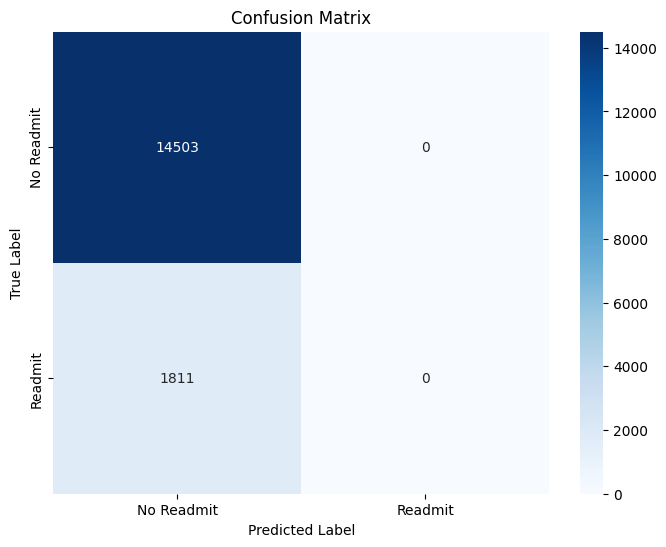

In [9]:
# Calculate metrics for the dev set
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import matplotlib.pyplot as plt

dev = pd.read_csv(DEV_PATH)

X_dev = dev.drop(columns=["readmit30"])
y_dev = dev["readmit30"].astype(int)

# Calculate metrics
y_true = y_dev.astype(int)
y_pred = clf.predict_proba(X_dev)[:, 1]

auroc = roc_auc_score(y_true, y_pred)
auprc = average_precision_score(y_true, y_pred)
brier = brier_score_loss(y_true, y_pred)

print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')
print(f'Brier Score: {brier:.4f}')

# Create figures
plt.figure(figsize=(10, 6))

# Histogram of predicted probabilities
plt.hist(y_pred, bins=20, alpha=0.7, label='Predicted Probabilities')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Scatter plot of true vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='True vs Predicted')
plt.title('True vs Predicted Probabilities')
plt.xlabel('True Labels')
plt.ylabel('Predicted Probabilities')
plt.legend()
plt.show()

# Create ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Create Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Create Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

threshold = 0.5  # Default threshold for binary classification
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Readmit', 'Readmit'], yticklabels=['No Readmit', 'Readmit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#MAINEND

## 5) Validate the predictions file format

This checks:
- required columns
- probabilities in [0, 1]
- row_ids match the test file

It assumes the submission notebook wrote `predictions.csv` in the repo root.


In [10]:
from pathlib import Path
pred_path = Path("predictions.csv")
test_path = Path("../scripts/data/public/public_test.csv")

if not pred_path.exists():
    print("predictions.csv not found. Run notebooks/submission.ipynb first.")
else:
    !python ../scripts/validate_submission.py --pred predictions.csv --test ../scripts/data/public/public_test.csv


OK: predictions.csv format is valid.


## 6) Commit + push + tag

You will:
- add changes
- commit (pre-commit hook runs here)
- push
- tag a milestone (example: `milestone_wk3`) and push tags



You will need a Personal Access Token (PAT) for the following step. See instructions above.

## Done ✅

If you hit issues:
- Make sure you pulled the latest course template (missing files).
- Make sure `data/public/*` exists in your repo (or your instructor provided it separately).
